# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

## Inicialización

In [1]:
# Cargar todas las librerías
from scipy import stats as st
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import seaborn as sns

## Cargar datos

In [2]:
# Carga los archivos de datos en diferentes DataFrames
df_calls = pd.read_csv('/datasets/megaline_calls.csv')
df_internet = pd.read_csv('/datasets/megaline_internet.csv')
df_messages = pd.read_csv('/datasets/megaline_messages.csv')
df_plans = pd.read_csv('/datasets/megaline_plans.csv')
df_users = pd.read_csv('/datasets/megaline_users.csv')

## Preparar los datos

## Tarifas

In [3]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas

df_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [4]:
# Imprime una muestra de los datos para las tarifas

print(df_plans.head())

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  


Observaciones

- No hay ningun problema evidente pero si puede haber si la tarifa por GB tuviera un cambio en centavos, igual que con el monto en la mensualidad. Por lo tanto es razonable cambiar ambas variables a float64.

- El nombre de la columna de "plan_name" es mejor cambiarlo a solo "plan" para que al momento de fusionar con datos de la columna de users no hayan inconvenientes

## Corregir datos

In [5]:
df_plans = df_plans.astype({
    'usd_monthly_pay': float,
    'usd_per_gb': float
})

df_plans = df_plans.rename(columns={'plan_name':'plan'})

In [6]:
df_plans.info()
df_plans = df_plans.drop_duplicates()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      float64
 4   usd_per_gb             2 non-null      float64
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan                   2 non-null      object 
dtypes: float64(4), int64(3), object(1)
memory usage: 256.0+ bytes


## Usuarios/as

In [7]:
# Imprime la información general/resumida sobre el DataFrame de usuarios
df_users.info()
df_users = df_users.drop_duplicates()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [8]:
# Imprime una muestra de datos para usuarios
print(df_users.sample(5))


     user_id first_name  last_name  age  \
405     1405     Shella     Hunter   34   
437     1437      Louis       Neal   42   
137     1137    Allegra    Hopkins   20   
460     1460    Winford  Underwood   46   
186     1186     Josiah    Douglas   55   

                                       city    reg_date      plan  churn_date  
405    Indianapolis-Carmel-Anderson, IN MSA  2018-06-22  ultimate         NaN  
437     Dallas-Fort Worth-Arlington, TX MSA  2018-11-12      surf         NaN  
137  Chicago-Naperville-Elgin, IL-IN-WI MSA  2018-10-02      surf         NaN  
460                          Fresno, CA MSA  2018-05-28  ultimate         NaN  
186    Las Vegas-Henderson-Paradise, NV MSA  2018-12-22  ultimate  2018-12-31  


Observaciones:
- Se presencian datos ausentes en churn date, indicando que el usuario todavia sigue usando el servicio. Con el metodo fillna se puede rellenar con Active los valores ausentes para que no hayan inconvenientes futuros.

### Corregir los datos

In [9]:
print (df_users.isna().sum())

user_id         0
first_name      0
last_name       0
age             0
city            0
reg_date        0
plan            0
churn_date    466
dtype: int64


In [10]:
df_users['churn_date'].fillna('Active', inplace= True)

In [11]:
print(df_users.sample(5))
print()
print (df_users.isna().sum())

     user_id first_name last_name  age  \
469     1469       Rory     Nixon   75   
396     1396    Ardelia    Benton   65   
291     1291    Angeles     Mejia   65   
192     1192      Korey   Goodwin   36   
331     1331  Lashandra     Ramos   54   

                                          city    reg_date  plan churn_date  
469  New York-Newark-Jersey City, NY-NJ-PA MSA  2018-06-04  surf     Active  
396                     Salt Lake City, UT MSA  2018-06-01  surf     Active  
291       Indianapolis-Carmel-Anderson, IN MSA  2018-01-29  surf     Active  
192                Buffalo-Cheektowaga, NY MSA  2018-10-02  surf     Active  
331        Dallas-Fort Worth-Arlington, TX MSA  2018-02-06  surf     Active  

user_id       0
first_name    0
last_name     0
age           0
city          0
reg_date      0
plan          0
churn_date    0
dtype: int64


## Llamadas

In [12]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
df_calls.info()
df_calls = df_calls.drop_duplicates()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [13]:
# Imprime una muestra de datos para las llamadas
print(df_calls.sample(5))


              id  user_id   call_date  duration
119145  1415_193     1415  2018-09-22     14.65
38496   1144_405     1144  2018-10-27      0.00
87096   1320_765     1320  2018-07-29      5.86
59949   1215_334     1215  2018-12-04     15.06
109579   1386_39     1386  2018-12-14     10.55


Observaciones:
- Al igual que en otros df, en esta seccion se puede adelantar el cambio de las fechas (call_date para este caso), de dato tipo object a datetime para extraer los meses por ejemplo, que van a ser importantes para los resumenes mensuales mas adelante. 

## Mensajes

In [14]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
df_messages.info()
df_messages = df_messages.drop_duplicates()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [15]:
# Imprime una muestra de datos para los mensajes
print(df_messages.sample(5))


             id  user_id message_date
49420  1328_378     1328   2018-07-23
20694   1131_33     1131   2018-08-07
22568  1133_823     1133   2018-10-05
38171  1251_223     1251   2018-12-24
15447  1101_504     1101   2018-05-21


Observaciones
- No hay errores evidentes en los tipos de datos y no hay valores nulos

### Corregir los datos

### Enriquecer los datos

## Internet

In [16]:
# Imprime la información general/resumida sobre el DataFrame de internet
df_internet.info()
df_internet = df_internet.drop_duplicates()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [17]:
# Imprime una muestra de datos para el tráfico de internet

print(df_internet.sample(5))

             id  user_id session_date  mb_used
77413   1362_81     1362   2018-11-02   399.32
56492  1255_228     1255   2018-08-25   584.66
63879  1293_228     1293   2018-11-29   831.44
58670  1263_474     1263   2018-09-16   354.83
20289  1094_135     1094   2018-10-31   643.93


Observaciones
- No hay errores evidentes en los tipos de datos y no hay valores nulos

## Estudiar las condiciones de las tarifas

In [18]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras
print("PLANES")
print("Plan Surf:")
print("  - Pago mensual: $20.")
print("  - 500 minutos al mes, 50 SMS y 15 GB de datos.")
print("  - Si se exceden los límites del paquete:")
print("     * 1 minuto: 3 centavos.")
print("     * 1 SMS: 3 centavos.")
print("     * 1 GB de datos: $10.")
print()
print("Plan Ultimate:")
print("  - Pago mensual: $70.")
print("  - 3000 minutos al mes, 1000 SMS y 30 GB de datos.")
print("  - Si se exceden los límites del paquete:")
print("     * 1 minuto: 1 centavo.")
print("     * 1 SMS: 1 centavo.")
print("     * 1 GB de datos: $7.")



PLANES
Plan Surf:
  - Pago mensual: $20.
  - 500 minutos al mes, 50 SMS y 15 GB de datos.
  - Si se exceden los límites del paquete:
     * 1 minuto: 3 centavos.
     * 1 SMS: 3 centavos.
     * 1 GB de datos: $10.

Plan Ultimate:
  - Pago mensual: $70.
  - 3000 minutos al mes, 1000 SMS y 30 GB de datos.
  - Si se exceden los límites del paquete:
     * 1 minuto: 1 centavo.
     * 1 SMS: 1 centavo.
     * 1 GB de datos: $7.


## Agregar datos por usuario



In [19]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.

#1. object to datetime
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'])

#2. extraer month
df_calls['month'] = df_calls['call_date'].dt.month

#3. count
calls_per_user = df_calls.groupby(['user_id','month']).agg({'id':'count'}).reset_index()
calls_per_user = calls_per_user.rename(columns = {'id':'calls_per_month'})

print(calls_per_user.sample(5))

      user_id  month  calls_per_month
1327     1292      7               17
1508     1334      9              132
1348     1296     12               54
131      1036     11               73
1224     1263      7               67


In [20]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.

#3. count
minutes_per_user = df_calls.groupby(['user_id','month']).agg({'duration':'sum'}).reset_index()
minutes_per_user = minutes_per_user.rename(columns = {'duration':'minutes_per_month'})

print(minutes_per_user.sample(5))


      user_id  month  minutes_per_month
169      1043      8             108.26
412      1088      5              21.25
1208     1261      2              53.34
2230     1494     10             585.82
1805     1397      6             753.72


In [21]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.

#1. object to datetime
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'])

#2. extraer month
df_messages['month'] = df_messages['message_date'].dt.month

#3. count
messages_per_user = df_messages.groupby(['user_id','month']).agg({'id':'count'}).reset_index()
messages_per_user = messages_per_user.rename(columns = {'id':'messages_per_month'})

print(messages_per_user.sample(5))

      user_id  month  messages_per_month
1286     1346      7                  44
318      1090      9                  21
1698     1466      9                  50
461      1128      8                  54
1423     1382      8                  53


In [22]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.

#1. object to datetime
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'])

#2. extraer month
df_internet['month'] = df_internet['session_date'].dt.month

#3. count
internet_per_user = df_internet.groupby(['user_id','month']).agg({'mb_used':'sum'}).reset_index()
internet_per_user = internet_per_user.rename(columns = {'mb_used':'mb_per_month'})

print(internet_per_user.sample(5))

      user_id  month  mb_per_month
2196     1481     12       1265.78
918      1191     11      14541.98
1050     1220     10      19456.48
762      1159     10      15861.99
1809     1390      9      11261.67


- Consumo al mes del usuario

In [23]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
user_data = calls_per_user.merge(minutes_per_user, on=['user_id', 'month'], how='outer')
user_data = user_data.merge(messages_per_user, on=['user_id', 'month'], how='outer')
user_data = user_data.merge(internet_per_user, on=['user_id', 'month'], how='outer')

#rellenando valores nulos
user_data[['minutes_per_month', 'messages_per_month', 'mb_per_month']]=user_data[['minutes_per_month', 'messages_per_month', 'mb_per_month']].fillna(0)

print(user_data.sample(5))

      user_id  month  calls_per_month  minutes_per_month  messages_per_month  \
2097     1464     11             68.0             500.51                31.0   
752      1160     11             75.0             499.20                10.0   
116      1031     11             85.0             575.18                 1.0   
334      1072      8             86.0             595.98                20.0   
1217     1261     11             73.0             533.77                46.0   

      mb_per_month  
2097      13309.59  
752       22695.93  
116       16198.94  
334       26667.58  
1217      15404.34  


In [24]:
# Añade la información de la tarifa
user_data = user_data.merge(df_users[['user_id','plan']], on='user_id', how='left') 
print(user_data)

      user_id  month  calls_per_month  minutes_per_month  messages_per_month  \
0        1000     12             16.0             116.83                11.0   
1        1001      8             27.0             171.14                30.0   
2        1001      9             49.0             297.69                44.0   
3        1001     10             65.0             374.11                53.0   
4        1001     11             64.0             404.59                36.0   
...       ...    ...              ...                ...                 ...   
2288     1349     12              NaN               0.00                61.0   
2289     1361      5              NaN               0.00                 2.0   
2290     1482     10              NaN               0.00                 2.0   
2291     1108     12              NaN               0.00                 0.0   
2292     1311      6              NaN               0.00                 0.0   

      mb_per_month      plan  
0       

- Ingresos mensuales por usuario 

In [25]:
# Calcula el ingreso mensual para cada usuario

# 1. Uniendo las condiciones de cada plan
user_data = user_data.drop(columns=['minutes_included', 'usd_per_minute',
    'messages_included', 'mb_per_month_included',
    'usd_per_message', 'usd_per_gb', 'usd_monthly_pay'
], errors='ignore')

user_data = user_data.merge(df_plans, on='plan',how = 'left')
print(user_data.sample(10))


# 2. Exceso de uso
user_data['extra_minutes'] = (user_data['minutes_per_month']-user_data['minutes_included']).clip(lower=0)
user_data['extra_messages'] = (user_data['messages_per_month']-user_data['messages_included']).clip(lower=0)
user_data['extra_mb'] = (user_data['mb_per_month']-user_data['mb_per_month_included']).clip(lower=0)
user_data['extra_gb'] = (user_data['extra_mb']/1024).apply(np.ceil)

#3. Monto mensual por usuario
user_data['monthly_revenue']=(user_data['usd_monthly_pay'] +
                             user_data['extra_minutes']*user_data['usd_per_minute'] +
                             user_data['extra_messages']*user_data['usd_per_message'] +
                             user_data['extra_gb']*user_data['usd_per_gb']
                             )

revenue_per_user_month = user_data[['user_id','month','plan','monthly_revenue']]
print(revenue_per_user_month.sample(10))

      user_id  month  calls_per_month  minutes_per_month  messages_per_month  \
1163     1252     12             66.0             460.24                35.0   
533      1114      9             87.0             594.70                95.0   
91       1027     10             58.0             393.25                12.0   
821      1174     12             92.0             610.78                76.0   
1703     1374      4              6.0              25.62                 5.0   
1072     1232     12             92.0             611.23                 3.0   
1462     1325     12             67.0             401.76                 0.0   
490      1106      5             35.0             161.89                 0.0   
25       1007     12             87.0             579.43                50.0   
1465     1326      9            121.0             791.82                74.0   

      mb_per_month  plan  messages_included  mb_per_month_included  \
1163      12730.13  surf                 50      

## Estudia el comportamiento de usuario

### Llamadas

              id  user_id  call_date  duration  month      plan
95204   1337_130     1337 2018-11-24      2.31     11      surf
40802   1150_705     1150 2018-11-08     21.93     11  ultimate
127763   1458_43     1458 2018-10-19      0.00     10  ultimate
15226   1061_168     1061 2018-08-31      8.70      8  ultimate
44218   1160_234     1160 2018-11-05      0.00     11      surf

        plan  month  duration
0       surf      1  6.428000
1       surf      2  6.906175
2       surf      3  6.696919
3       surf      4  6.799918
4       surf      5  6.769200
5       surf      6  6.846812
6       surf      7  6.721710
7       surf      8  6.726164
8       surf      9  6.728684
9       surf     10  6.722302
10      surf     11  6.759115
11      surf     12  6.836607
12  ultimate      1  6.541518
13  ultimate      2  6.517230
14  ultimate      3  6.210906
15  ultimate      4  6.659990
16  ultimate      5  6.662443
17  ultimate      6  6.705188
18  ultimate      7  6.879085
19  ultimate   

<Figure size 800x300 with 0 Axes>

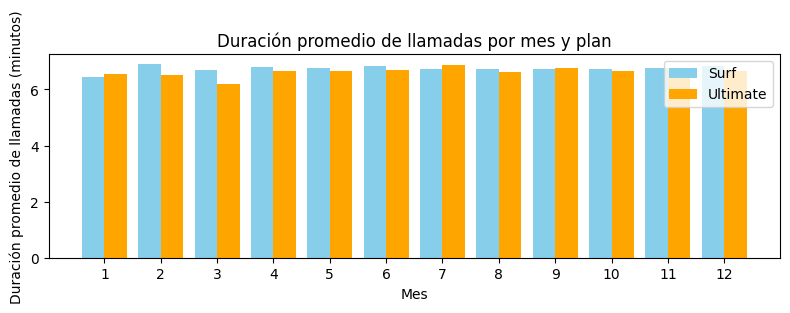

In [26]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.

df_calls['call_date'] = pd.to_datetime(df_calls['call_date'])
df_calls['month'] = df_calls['call_date'].dt.month
calls_with_plan = df_calls.merge(df_users[['user_id','plan']], on='user_id')
print(calls_with_plan.sample(5))

avg_duration = (
    calls_with_plan
    .groupby(['plan', 'month'])['duration']
    .mean()
    .reset_index()
)

print()
print(avg_duration)
print()
plt.figure(figsize=(8,3))

print()
surf_values_calls = avg_duration[avg_duration['plan']=='surf']['duration']
ultimate_values_calls = avg_duration[avg_duration['plan']=='ultimate']['duration']
months_calls = avg_duration[avg_duration['plan']=='surf']['month']

# posiciones para las barras
x = np.arange(len(months_calls))
width = 0.4

plt.figure(figsize=(8,3))
plt.bar(x - width/2, surf_values_calls, width, label='Surf', color='skyblue')
plt.bar(x + width/2, ultimate_values_calls, width, label='Ultimate', color='orange')

plt.title("Duración promedio de llamadas por mes y plan")
plt.xlabel("Mes")
plt.ylabel("Duración promedio de llamadas (minutos)")
plt.xticks(x, months_calls)
plt.legend()
plt.tight_layout()
plt.show()

      user_id  month  minutes_per_month      plan
138      1039      7             428.72  ultimate
855      1182     11             217.90      surf
1910     1415      7             560.92      surf
2114     1467      4             222.93  ultimate
2046     1449     10             355.09      surf
1052     1228     10             174.07      surf
1360     1299     11             590.06      surf
1667     1365     10            1163.31      surf
255      1059      7             672.10  ultimate
2193     1488      7             589.73      surf


<Figure size 800x300 with 0 Axes>

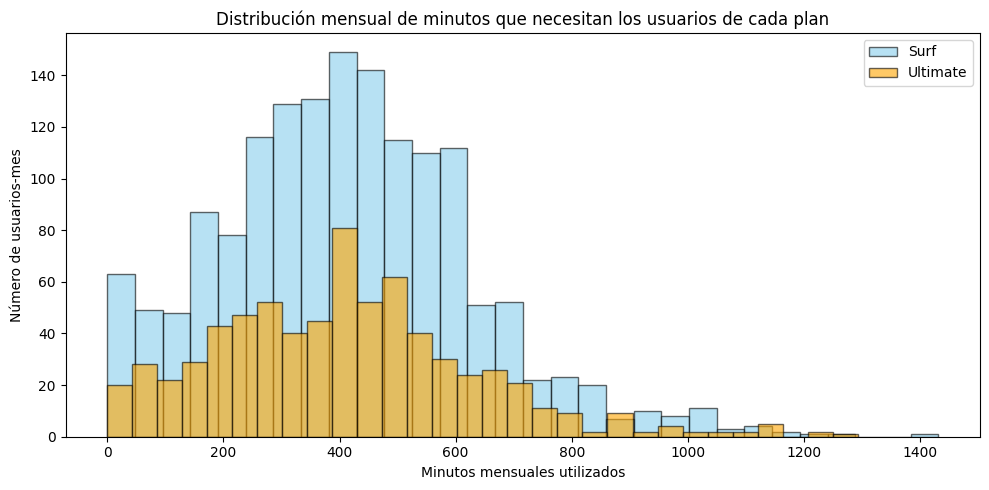

In [27]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.
# usando minutes_per_user (consumo de minutos al mes)
minutes_user_plan = minutes_per_user.merge(df_users[['user_id','plan']], on='user_id')
print(minutes_user_plan.sample(10))

plt.figure(figsize=(8,3))

# Separar por plan
surf_min = minutes_user_plan[minutes_user_plan['plan'] == 'surf']['minutes_per_month']
ultimate_min = minutes_user_plan[minutes_user_plan['plan'] == 'ultimate']['minutes_per_month']

# Histograma 
plt.figure(figsize=(10,5))
plt.hist(surf_min, bins=30, alpha=0.6, label='Surf', color='skyblue', edgecolor='black')
plt.hist(ultimate_min, bins=30, alpha=0.6, label='Ultimate', color='orange', edgecolor='black')

plt.title("Distribución mensual de minutos que necesitan los usuarios de cada plan")
plt.xlabel("Minutos mensuales utilizados")
plt.ylabel("Número de usuarios-mes")
plt.legend()
plt.tight_layout()
plt.show()

- Media y variable de la duración de las llamadas

In [28]:
# Calcula la media y la varianza de la duración mensual de llamadas.

stats_by_plan=(
    minutes_user_plan.groupby('plan')['minutes_per_month'].agg(['mean','var']).reset_index()
)

print()
print(stats_by_plan)


       plan        mean           var
0      surf  412.097890  47001.254231
1  ultimate  410.180954  50510.631705


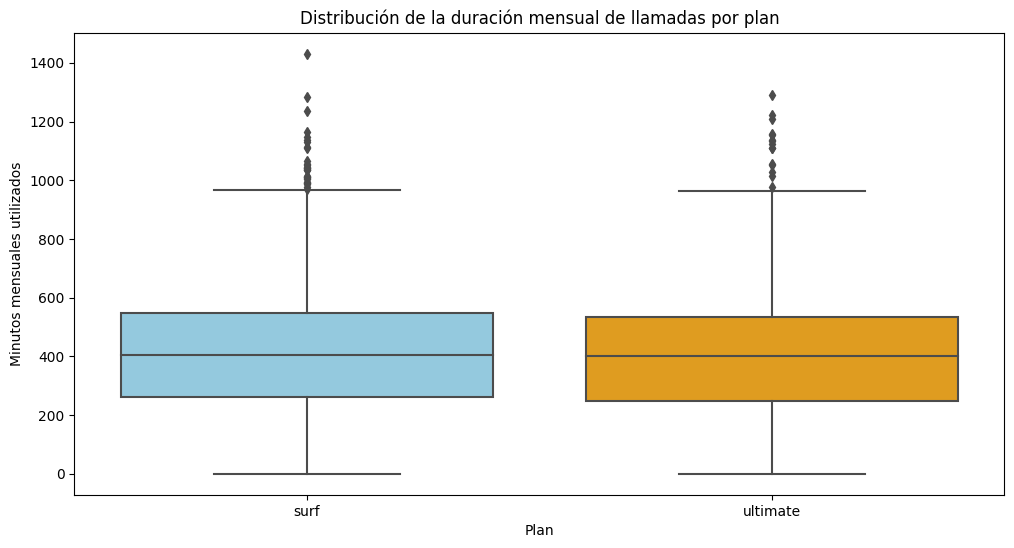

In [29]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas
plt.figure(figsize=(12,6))
sns.boxplot(
    data=minutes_user_plan,
    x='plan',
    y='minutes_per_month',
    order=['surf','ultimate'],
    palette={'surf':'skyblue', 'ultimate':'orange'}
).set(title = 'Distribución de la duración mensual de llamadas por plan',
xlabel = 'Plan',
ylabel = 'Minutos mensuales utilizados')
plt.show()

Conclusiones (llamadas):
- De acuerdo al grafico de barras, la duracion promedio de llamadas por mes para cada plan es bastante similar, siendo un promedio de mas de 6 minutos al mes para cada plan.
- De acuerdo al histograma, se puede ver que para ambos planes, la mayoria de los usuarios necesitan entre 300 y 600 minutos. Recordando que para el plan de surf el limite de minutos son 500 min/mes, es mas facil que los usuarios de este plan cobran excesos, en comparacion a los del plan ultimate que tienen acceso a 3000 min/mes sin exceso.  
Tambien gracias al histograma, se evidencia la diferencia en cantidad de usuarios por mes para ambos planes, siendo surf el mas recurrente.
- De acuerdo al diagrama de caja, la mediana ronda 400 min/mes para ambos planes. Ademas se evidencia que para ambos planes, aunque son pocos, existen usuarios que exceden los 1000 min/mes.   

### Mensajes

      user_id  month  messages_per_month      plan
54       1020     12                   3      surf
1037     1270      9                  13  ultimate
1369     1365      7                  52      surf
257      1077      5                  77  ultimate
993      1260     12                  80      surf

        plan  month  messages_per_month
0       surf      1           21.000000
1       surf      2           21.600000
2       surf      3           21.937500
3       surf      4           24.166667
4       surf      5           33.017857
5       surf      6           33.616438
6       surf      7           35.945055
7       surf      8           37.596774
8       surf      9           39.523179
9       surf     10           42.433862
10      surf     11           40.553097
11      surf     12           48.326772
12  ultimate      1           20.666667
13  ultimate      2           25.166667
14  ultimate      3           34.714286
15  ultimate      4           28.937500
16  ultimate 

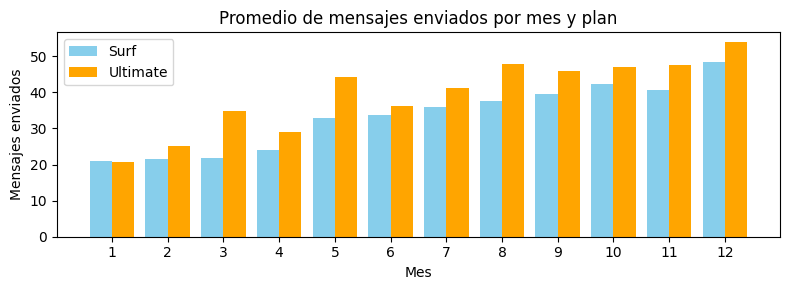

In [30]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan

messages_with_plan = messages_per_user.merge(df_users[['user_id','plan']], on='user_id')
print(messages_with_plan.sample(5))
print()

avg_messages = (
    messages_with_plan
    .groupby(['plan', 'month'])['messages_per_month']
    .mean()
    .reset_index()
)
print(avg_messages)
print()
surf_values_msg = avg_messages[avg_messages['plan']=='surf']['messages_per_month']
ultimate_values_msg = avg_messages[avg_messages['plan']=='ultimate']['messages_per_month']
months_msg = avg_messages[avg_messages['plan']=='surf']['month']

# posiciones para las barras
x = np.arange(len(months_msg))
width = 0.4

plt.figure(figsize=(8,3))
plt.bar(x - width/2, surf_values_msg, width, label='Surf', color='skyblue')
plt.bar(x + width/2, ultimate_values_msg, width, label='Ultimate', color='orange')

plt.title("Promedio de mensajes enviados por mes y plan")
plt.xlabel("Mes")
plt.ylabel("Mensajes enviados")
plt.xticks(x, months_msg)
plt.legend()
plt.tight_layout()
plt.show()


<Figure size 800x300 with 0 Axes>

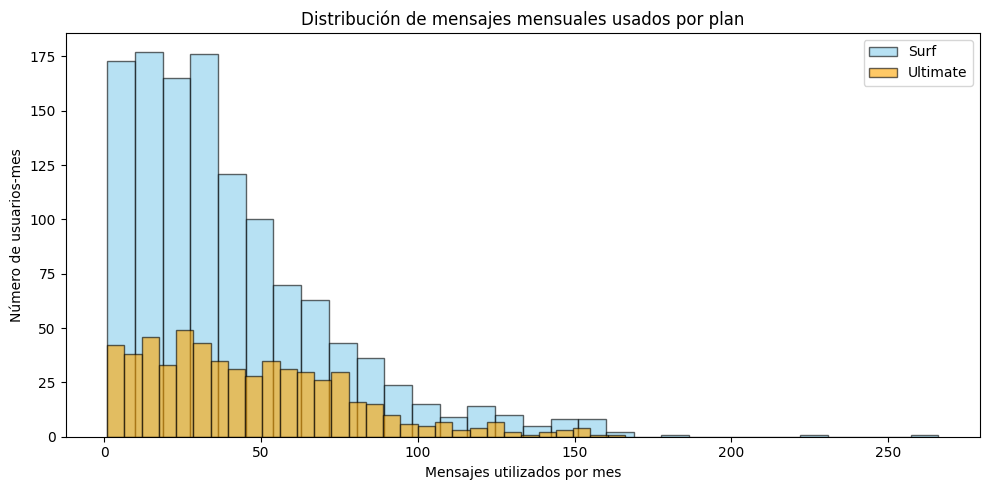

In [31]:
# Compara el número de mensajes mensuales que necesitan los usuarios de cada plan. Traza un histograma.
# usando messages_per_user (consumo de mensajes al mes)

plt.figure(figsize=(8,3))

# Separar por plan
surf_msg = messages_with_plan[messages_with_plan['plan'] == 'surf']['messages_per_month']
ultimate_msg = messages_with_plan[messages_with_plan['plan'] == 'ultimate']['messages_per_month']

# Histograma 
plt.figure(figsize=(10,5))
plt.hist(surf_msg, bins=30, alpha=0.6, label='Surf', color='skyblue', edgecolor='black')
plt.hist(ultimate_msg, bins=30, alpha=0.6, label='Ultimate', color='orange', edgecolor='black')

plt.title("Distribución de mensajes mensuales usados por plan")
plt.xlabel("Mensajes utilizados por mes")
plt.ylabel("Número de usuarios-mes")
plt.legend()
plt.tight_layout()
plt.show()

In [32]:
# Calcula la media y la varianza de los mensajes enviados por mes.

stats_by_plan_m=(
    messages_with_plan.groupby('plan')['messages_per_month'].agg(['mean','var']).reset_index()
)

print()
print(stats_by_plan_m)


       plan       mean          var
0      surf  40.109656  1091.344231
1  ultimate  46.296233  1085.183108


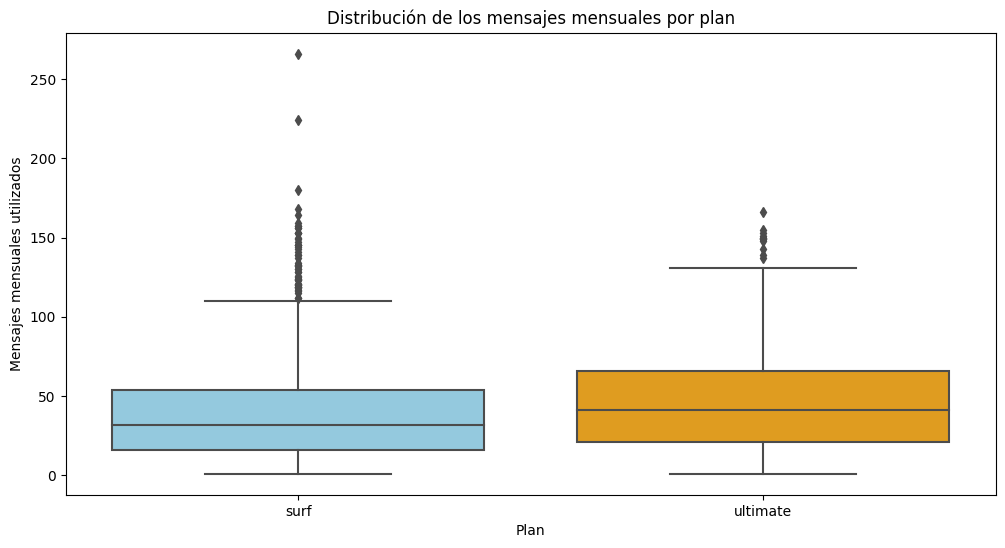

In [33]:
# Traza un diagrama de caja para visualizar la distribución de los mensajes enviados por mes.
plt.figure(figsize=(12,6))
sns.boxplot(
    data = messages_with_plan,
    x = 'plan',
    y = 'messages_per_month',
    order=['surf','ultimate'],
    palette={'surf':'skyblue', 'ultimate':'orange'}
).set(title = 'Distribución de los mensajes mensuales por plan',
xlabel = 'Plan',
ylabel = 'Mensajes mensuales utilizados')
plt.show()

Conclusiones (mensajes):
- Como se muestra en el grafico de barras, el nro de mensajes que tienden a enviar los usuario por mes es ligeramente mayor en el plan ultimate que en el surf, rondando el promedio a mas de 40 mensajes por mes para el ultimate. 
- De acuerdo al histograma, los usuarios de surf necesitan entre 20 y 50 mensajes al mes, mientras que los del plan ultimate necesitan entre 20 y 60 mensajes mensuales.
- Observando el diagrama de caja, visualmente, la mediana del plan surf ronda los 30 msg/mes mientras que la mediana del plan ultimate ronda los 40 msg/mes. Aunque si existen, son pocos los usuarios que envian mas de 100 mensajes por mes, siendo este comportamiento mas notable en los usuarios del plan surf.

### Internet

      user_id  month  mb_per_month      plan
439      1094     11      28448.40      surf
1039     1217     11      22923.77      surf
2181     1476      9      11263.34  ultimate
1434     1313      7      17701.73      surf
226      1054      7      16285.92      surf

        plan  month  mb_per_month
0       surf      1   4874.860000
1       surf      2  12178.843333
2       surf      3  13345.440000
3       surf      4  12228.778571
4       surf      5  14119.728026
5       surf      6  15623.666632
6       surf      7  16923.463917
7       surf      8  17112.224403
8       surf      9  16677.397254
9       surf     10  17533.275256
10      surf     11  16455.548043
11      surf     12  18189.669590
12  ultimate      1   6918.092500
13  ultimate      2  17128.808571
14  ultimate      3  18321.518333
15  ultimate      4  16121.654762
16  ultimate      5  16624.482414
17  ultimate      6  15337.921064
18  ultimate      7  16344.744407
19  ultimate      8  17814.720141
20  ultimate   

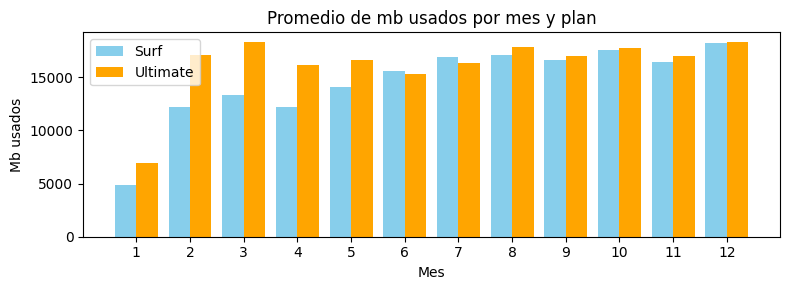

In [35]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan

internet_with_plan = internet_per_user.merge(df_users[['user_id','plan']], on='user_id')
print(internet_with_plan.sample(5))
print()

avg_internet = (
    internet_with_plan
    .groupby(['plan', 'month'])['mb_per_month']
    .mean()
    .reset_index()
)
print(avg_internet)
print()

surf_values_int = avg_internet[avg_internet['plan']=='surf']['mb_per_month']
ultimate_values_int = avg_internet[avg_internet['plan']=='ultimate']['mb_per_month']
months_int = avg_internet[avg_internet['plan']=='surf']['month']

# posiciones para las barras
x = np.arange(len(months_int))
width = 0.4

plt.figure(figsize=(8,3))
plt.bar(x - width/2, surf_values_int, width, label='Surf', color='skyblue')
plt.bar(x + width/2, ultimate_values_int, width, label='Ultimate', color='orange')

plt.title("Promedio de mb usados por mes y plan")
plt.xlabel("Mes")
plt.ylabel("Mb usados")
plt.xticks(x, months_int)
plt.legend()
plt.tight_layout()
plt.show()

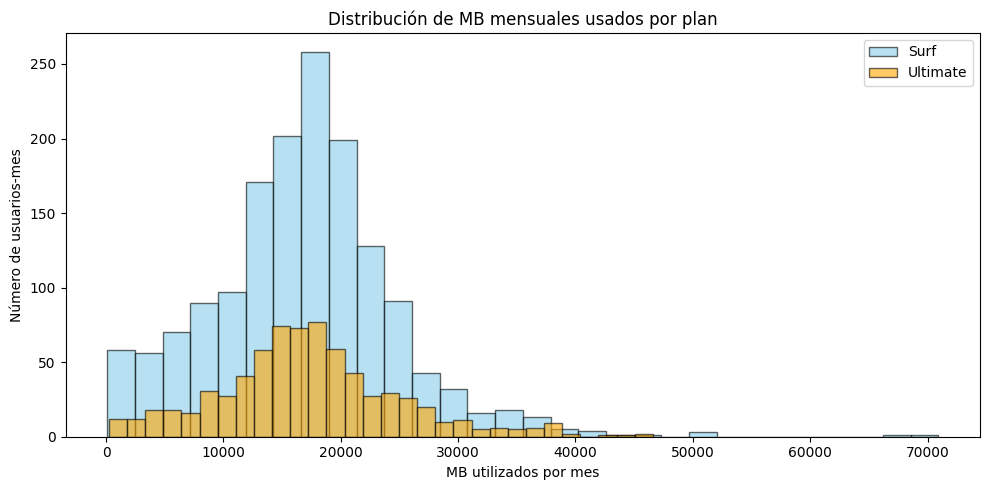

In [36]:
# Compara el número de mb mensuales que necesitan los usuarios de cada plan. Traza un histograma.
# usando internet_per_user (consumo de mb al mes)

# Separar por plan
surf_mb = internet_with_plan[internet_with_plan['plan'] == 'surf']['mb_per_month']
ultimate_mb = internet_with_plan[internet_with_plan['plan'] == 'ultimate']['mb_per_month']

# Histograma 
plt.figure(figsize=(10,5))
plt.hist(surf_mb, bins=30, alpha=0.6, label='Surf', color='skyblue', edgecolor='black')
plt.hist(ultimate_mb, bins=30, alpha=0.6, label='Ultimate', color='orange', edgecolor='black')

plt.title("Distribución de MB mensuales usados por plan")
plt.xlabel("MB utilizados por mes")
plt.ylabel("Número de usuarios-mes")
plt.legend()
plt.tight_layout()
plt.show()

In [37]:
# Calcula la media y la varianza de los mensajes mb usados por mes.

stats_by_plan_i=(
    internet_with_plan.groupby('plan')['mb_per_month'].agg(['mean','var']).reset_index()
)

print()
print(stats_by_plan_i)


       plan          mean           var
0      surf  16717.702137  6.216823e+07
1  ultimate  17238.642253  6.132485e+07


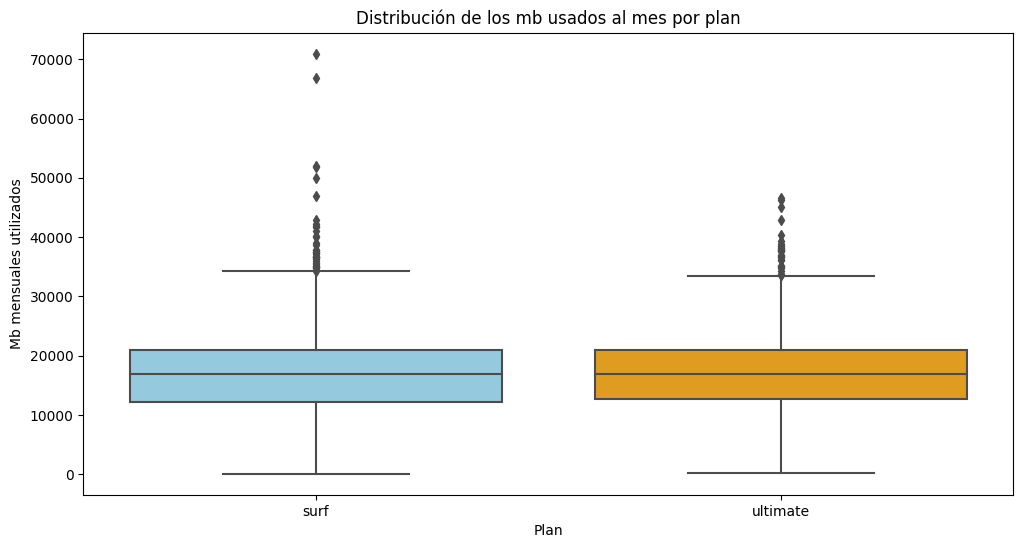

In [38]:
# Traza un diagrama de caja para visualizar la distribución de los mb usados por mes.
plt.figure(figsize=(12,6))
sns.boxplot(
    data = internet_with_plan,
    x = 'plan',
    y = 'mb_per_month',
    order=['surf','ultimate'],
    palette={'surf':'skyblue', 'ultimate':'orange'}
).set(title = 'Distribución de los mb usados al mes por plan',
xlabel = 'Plan',
ylabel = 'Mb mensuales utilizados')
plt.show()

Conclusiones (internet):
- En el grafico de barras del promedio de mb usados, se nota que en los meses antes del 6(junio), el promedio de mb usados por usuarios ultimate es mayor. Sin embargo, el consumo de mb promedio en los otros meses es mas similar o parejo, rondando un promedio de 17000 mb/mes.
- De acuerdo al histograma, para ambos planes, la mayoria de los usuarios consumen entre 12000 y 20000 mb/mes, siendo mas frecuente para los usuarios del plan surf exceder los limites que ofrece el plan de datos.
- Como muestra el diagrama de caja, la mediana ronda los 17000 mb/mes para ambos planes. Aunque no es comun, el diagrama muestra que hay usuarios que consumen mas de 50000 mb/mes. 

## Ingreso

        plan  month  monthly_revenue
0       surf      1        20.000000
1       surf      2        34.256733
2       surf      3        45.790261
3       surf      4        40.454700
4       surf      5        47.235155
5       surf      6        48.930735
6       surf      7        62.221942
7       surf      8        63.572562
8       surf      9        57.948540
9       surf     10        65.046710
10      surf     11        57.628813
11      surf     12        70.102687
12  ultimate      1        70.000000
13  ultimate      2        70.000000
14  ultimate      3        74.666667
15  ultimate      4        73.000000
16  ultimate      5        70.724138
17  ultimate      6        71.638298
18  ultimate      7        71.898305
19  ultimate      8        72.859155
20  ultimate      9        72.034884
21  ultimate     10        72.311321
22  ultimate     11        71.708661
23  ultimate     12        73.291391



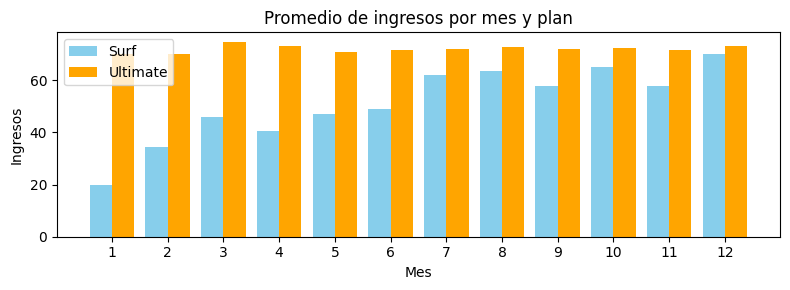

In [39]:
avg_revenue = (
    revenue_per_user_month
    .groupby(['plan', 'month'])['monthly_revenue']
    .mean()
    .reset_index()
)
print(avg_revenue)
print()

surf_values_rev = avg_revenue[avg_revenue['plan']=='surf']['monthly_revenue']
ultimate_values_rev = avg_revenue[avg_revenue['plan']=='ultimate']['monthly_revenue']
months_rev = avg_revenue[avg_revenue['plan']=='surf']['month']

# posiciones para las barras
x = np.arange(len(months_rev))
width = 0.4

plt.figure(figsize=(8,3))
plt.bar(x - width/2, surf_values_rev, width, label='Surf', color='skyblue')
plt.bar(x + width/2, ultimate_values_rev, width, label='Ultimate', color='orange')

plt.title("Promedio de ingresos por mes y plan")
plt.xlabel("Mes")
plt.ylabel("Ingresos")
plt.xticks(x, months_rev)
plt.legend()
plt.tight_layout()
plt.show()



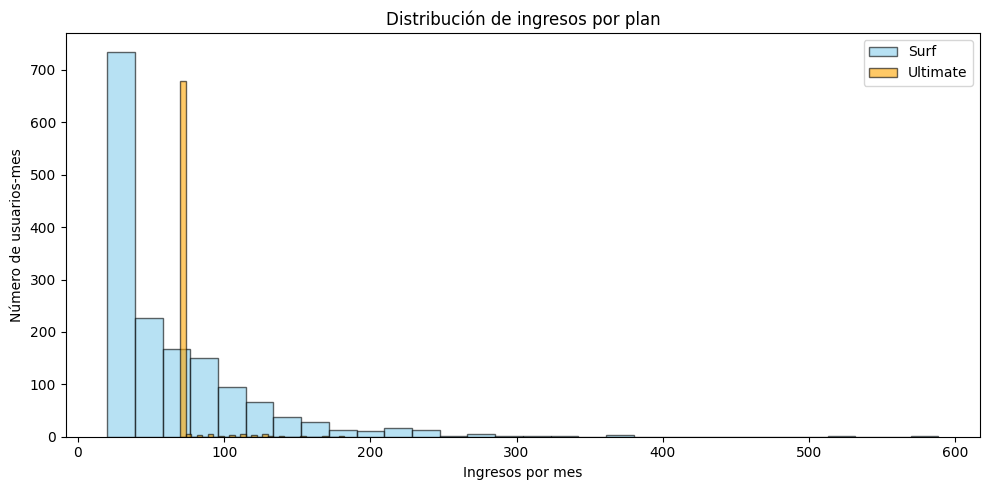

In [40]:
# Compara los ingresos mensuales que necesitan los usuarios de cada plan. Traza un histograma.
# usando revenue_per_user_month (ingresos al mes)

# Separar por plan
surf_rev = revenue_per_user_month[revenue_per_user_month['plan'] == 'surf']['monthly_revenue']
ultimate_rev = revenue_per_user_month[revenue_per_user_month['plan'] == 'ultimate']['monthly_revenue']

# Histograma 
plt.figure(figsize=(10,5))
plt.hist(surf_rev, bins=30, alpha=0.6, label='Surf', color='skyblue', edgecolor='black')
plt.hist(ultimate_rev, bins=30, alpha=0.6, label='Ultimate', color='orange', edgecolor='black')

plt.title("Distribución de ingresos por plan")
plt.xlabel("Ingresos por mes")
plt.ylabel("Número de usuarios-mes")
plt.legend()
plt.tight_layout()
plt.show()

In [41]:
# Calcula la media y la varianza de los ingresos por mes.

stats_by_plan_rev=(
    revenue_per_user_month.groupby('plan')['monthly_revenue'].agg(['mean','var']).reset_index()
)

print()
print(stats_by_plan_rev)


       plan       mean          var
0      surf  60.327346  3053.955465
1  ultimate  72.313889   129.848486


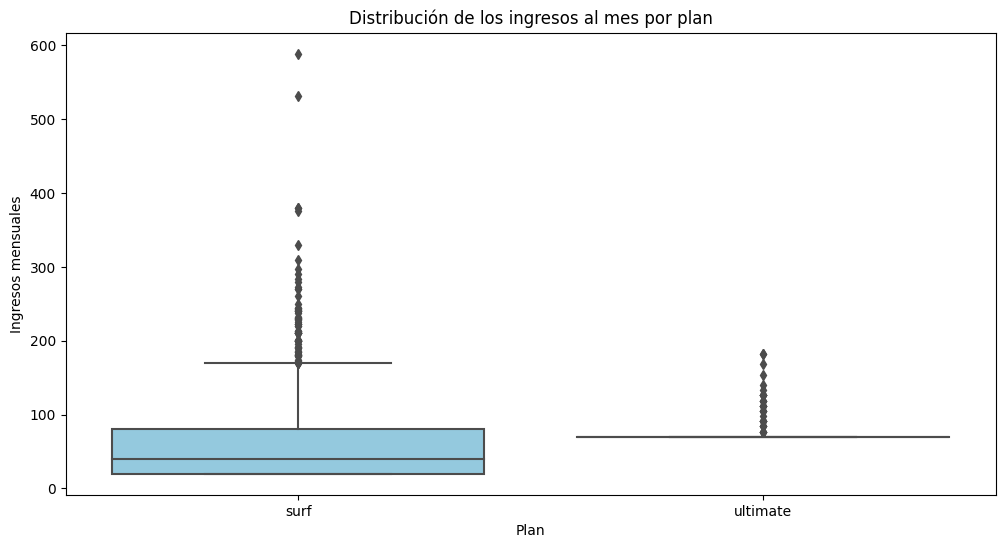

In [42]:
# Traza un diagrama de caja para visualizar la distribución de los ingresos por mes.
plt.figure(figsize=(12,6))
sns.boxplot(
    data = revenue_per_user_month,
    x = 'plan',
    y = 'monthly_revenue',
    order=['surf','ultimate'],
    palette={'surf':'skyblue', 'ultimate':'orange'}
).set(title = 'Distribución de los ingresos al mes por plan',
xlabel = 'Plan',
ylabel = 'Ingresos mensuales')
plt.show()

Conclusiones (ingresos):
- Para analizar mejor el grafico de barras, es bueno recordar que el pago mensual de surf y ultimate es 20 y 70 usd, respectivamente. El grafico muestra que el promedio de ingresos de ultimate es muy parejo, y no es tan notable la presencia de cargos extras para los usuarios. En cambio para el plan surf, los ingresos aumentaron entre el mes 7 y 12 (julio y diciembre), llegando a alcanzar ingresos que rondan los 60 usd mensuales, es decir 3 veces mas del costo del plan originalmente.

- De acuerdo al histograma, la mayoria de usuarios del plan ultimate necesitan 
70 usd de ingreso, mientras que para el plan surf aunque la mayoria de usuarios necesita 20 usd de ingreso, hay usuarios que necesitan entre 40 y 60 usd.

- Del diagrama de caja se visualiza que la mediana del plan surf ronda los 40 usd mientras que en el plan ultimate son los mismos 70 usd del costo base de mensualidad del plan. 


## Prueba las hipótesis estadísticas

In [43]:
# Prueba las hipótesis
alpha=0.05
results = st.ttest_ind(surf_min, ultimate_min, equal_var=False)

print('Valor p:',results.pvalue)

if results.pvalue < alpha: 
 print("Rechazamos la hipótesis nula") 
else: 
 print("No podemos rechazar la hipótesis nula") 

Valor p: 0.8489512286028894
No podemos rechazar la hipótesis nula


In [44]:
# Prueba las hipótesis

# Unimos city con los ingresos por usuario y mes
user_income = user_data[['user_id','monthly_revenue']].merge(df_users[['user_id', 'city']], on='user_id', how='left')
print (user_income.head())

#separando en grupos. Comparar con "New York-Newark-Jersey City, NY-NJ-PA MSA" para no tener errores
ny_nj_income = user_income[user_income['city'] == 'New York-Newark-Jersey City, NY-NJ-PA MSA']['monthly_revenue'].dropna()
other_income = user_income[user_income['city'] != 'New York-Newark-Jersey City, NY-NJ-PA MSA']['monthly_revenue'].dropna()

alpha=0.05
results = st.ttest_ind(ny_nj_income, other_income, equal_var=False)

print('Valor p:',results.pvalue)

if results.pvalue < alpha: 
 print("Rechazamos la hipótesis nula") 
else: 
 print("No podemos rechazar la hipótesis nula") 

   user_id  monthly_revenue                                   city
0     1000            70.00  Atlanta-Sandy Springs-Roswell, GA MSA
1     1001            20.00        Seattle-Tacoma-Bellevue, WA MSA
2     1001            20.00        Seattle-Tacoma-Bellevue, WA MSA
3     1001            90.09        Seattle-Tacoma-Bellevue, WA MSA
4     1001            60.00        Seattle-Tacoma-Bellevue, WA MSA
Valor p: 0.031214139070912954
Rechazamos la hipótesis nula


## Conclusión general
1.15. 

a. Diferencias de las duraciones medias de llamadas entre planes. Como el valor p es mayor que alpha, no se puede rechazar la hipótesis nula. No hay evidencia significativa que demuestre una diferencia entre los planes con respecto a las duraciones medias de llamadas. 

b. Rechazamos la hipótesis nula de que el ingreso promedio de los usuarios de NY-NJ es igual al de otras regiones. Hay una diferencia significtiva en el ingreso promedio entre NY-NJ y otras regiones. 